In [63]:
#################################################################### Loading packages ####################################################################
%matplotlib inline
import numpy as np
import scipy.stats as scs
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap
from tqdm import tqdm
import pickle
import math 
import re
from Censored_copula import truncgauss
from scipy.spatial import distance_matrix

#################################################################### Loading GNM ####################################################################
model_version = 0 
target_distribution = "gamma_hurdle"
base_nn = "HConvLSTM_tdscale"
sys.path.append('../')
import glms
import pickle
import torch

path_ = f"Checkpoints/uk_rain_DGLM_{base_nn}_{target_distribution}/lightning_logs/version_{model_version}/"
#ckpt_path = glms.NeuralDGLM.get_ckpt_path(os.path.join(path_,"checkpoints"))
ckpt_path = 'Checkpoints/uk_rain_DGLM_HConvLSTM_tdscale_gamma_hurdle/lightning_logs/version_0/checkpoints/epoch=3-step=9008-val_loss_loss=-0.552-val_metric_mse_rain=26.500.ckpt'
print([path_,ckpt_path])

scaler_features, scaler_target = glms.NeuralDGLM.load_scalers(path_)
model = glms.NeuralDGLM.load_from_checkpoint(ckpt_path, save_hparams=False, scaler_features=scaler_features, scaler_target=scaler_target)
model.freeze()
model.eval()

GNM_output = pickle.load( open(os.path.join(path_,"test_output_1999-07_2019-07.pkl"),"rb") )

#################################################################### Problematic locations? ###############################################################

location_keys = list(GNM_output.keys())                 # '([0, 16], [44, 60])', ...
output_keys = list(GNM_output[location_keys[0]].keys()) # 0'pred_mu', 1'pred_disp', 2'target_did_rain', 3'target_rain_value', 4'date', 5'pred_p', 6'mask', 7'idx_loc_in_region'


# May have to remove a location that doesn't have 2002 days:
location_keys.remove(location_keys[344])

#################################################################### Utility functions ####################################################################
def give_lat_lon(location_key):
    return [ int(re.findall(r'\d+',string)[0]) for string in location_key.split(',')]

def is_loc_land(location,row,column):
    return GNM_output[location]['mask'][0][row][column]

#location_keys.remove('lat_50.95_49.35_lon_-4.55_-2.95') # 'lat_50.95_49.35_lon_-4.55_-2.95' has no data after week indexed 255, so I did not consider it.
#day_dates = [GNM_output[location_keys[100]]['date'][0]+np.timedelta64(i, 'D') for i in range(2002)]
output_keys.remove('idx_loc_in_region') # not usefull
output_keys.remove('date') # no more usefull

#################################################################### Making list for land locations ####################################################################
#GNM_landonly[location][param][day]
# 0'pred_mu', 1'pred_disp', 2'target_did_rain', 3'target_rain_value', 4'pred_p', 5'location'

GNM_landonly = [] 
land_counter = -1
for location in tqdm(location_keys):
    for col in range(4):
        for row in range(4):
            if not is_loc_land(location,row,col):#check if land
               continue  
            land_counter+=1
            GNM_landonly.append([[],[],[],[],[]]) # parameters except location
            temp_lat_lon = give_lat_lon(location)
            GNM_landonly[land_counter].append([temp_lat_lon[1]-8+row,(temp_lat_lon[2])+6+col]) #location
            for param_idx,param in enumerate(output_keys[:-1]):
                for day in range(7301):
                
                    GNM_landonly[land_counter][param_idx].append(GNM_output[location][param][day][row,col])

dist_mat = distance_matrix(np.matrix([[GNM_landonly[loc][5][0],GNM_landonly[loc][5][1]] for loc in range(4087)]),np.matrix([[GNM_landonly[loc][5][0],GNM_landonly[loc][5][1]] for loc in range(len(GNM_landonly))]))


['Checkpoints/uk_rain_DGLM_HConvLSTM_tdscale_gamma_hurdle/lightning_logs/version_0/', 'Checkpoints/uk_rain_DGLM_HConvLSTM_tdscale_gamma_hurdle/lightning_logs/version_0/checkpoints/epoch=3-step=9008-val_loss_loss=-0.552-val_metric_mse_rain=26.500.ckpt']


c:\Users\u1819911\Anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\u1819911\Anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
100%|██████████| 344/344 [01:10<00:00,  4.88it/s]


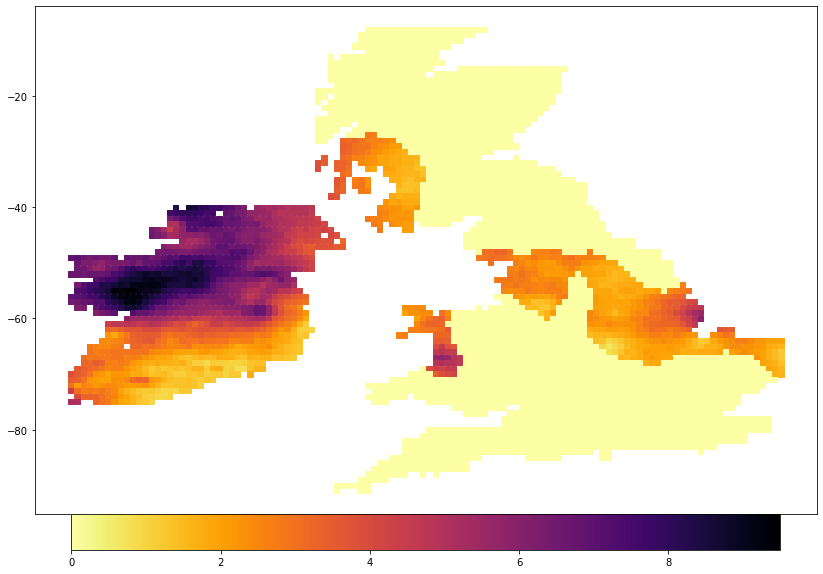

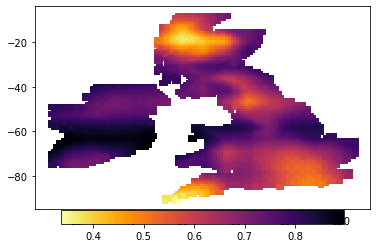

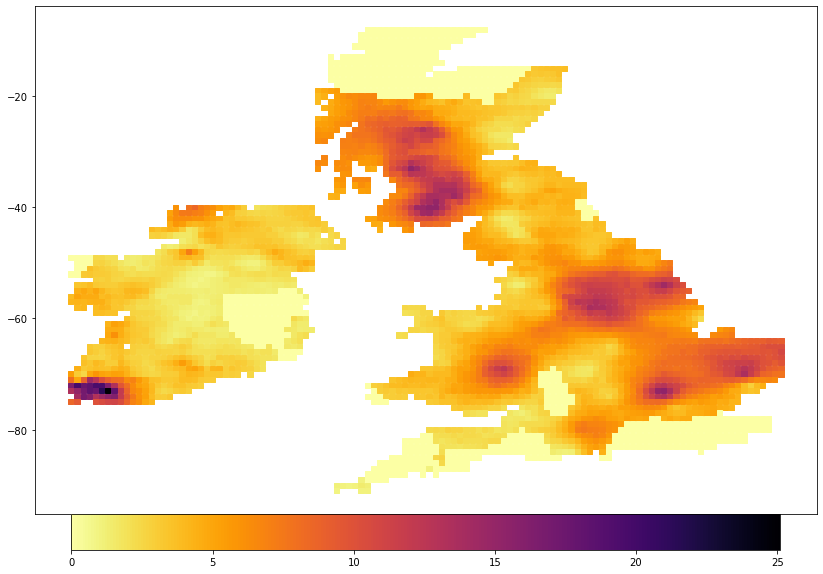

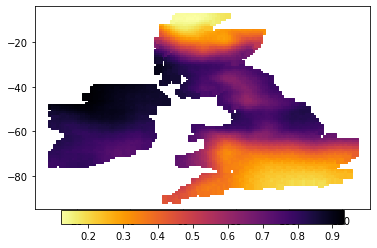

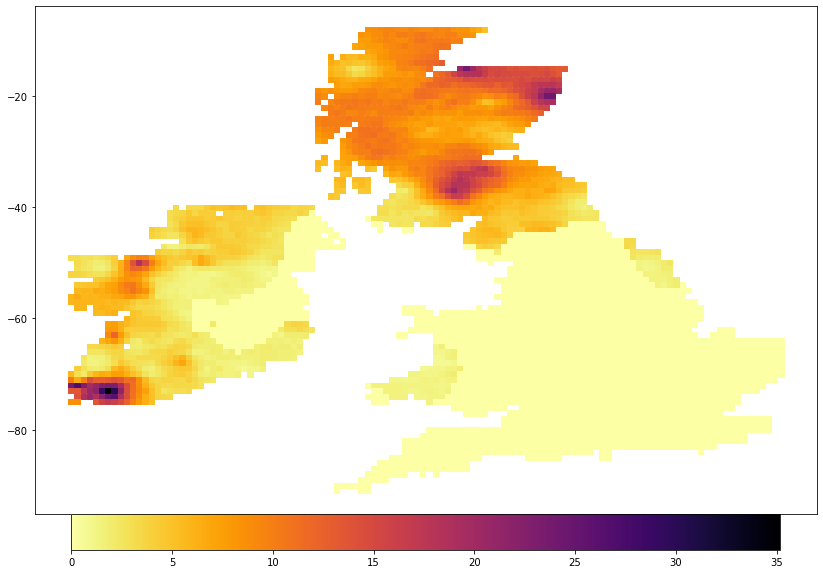

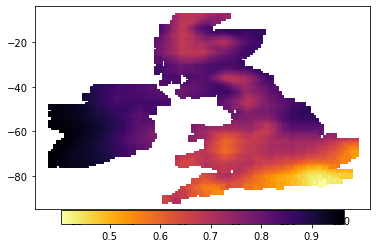

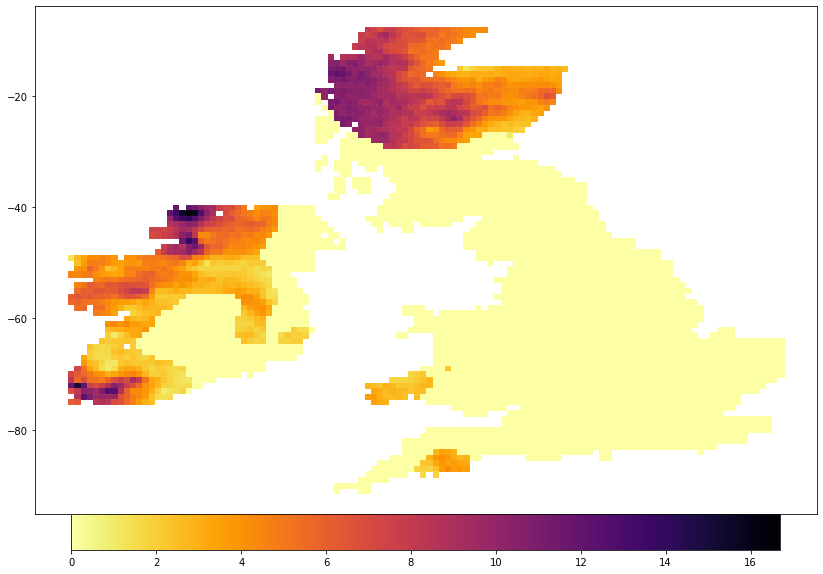

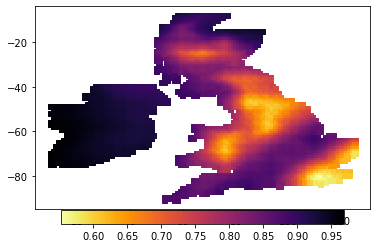

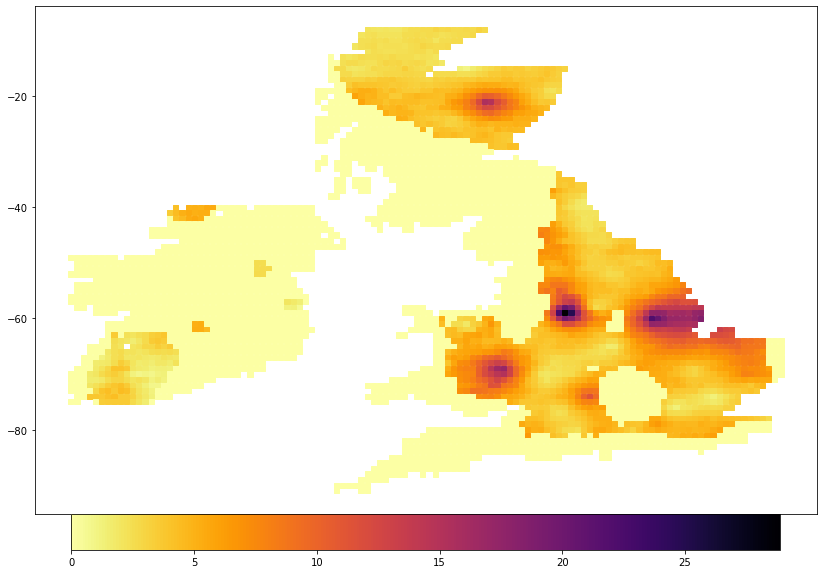

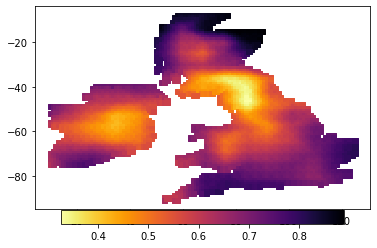

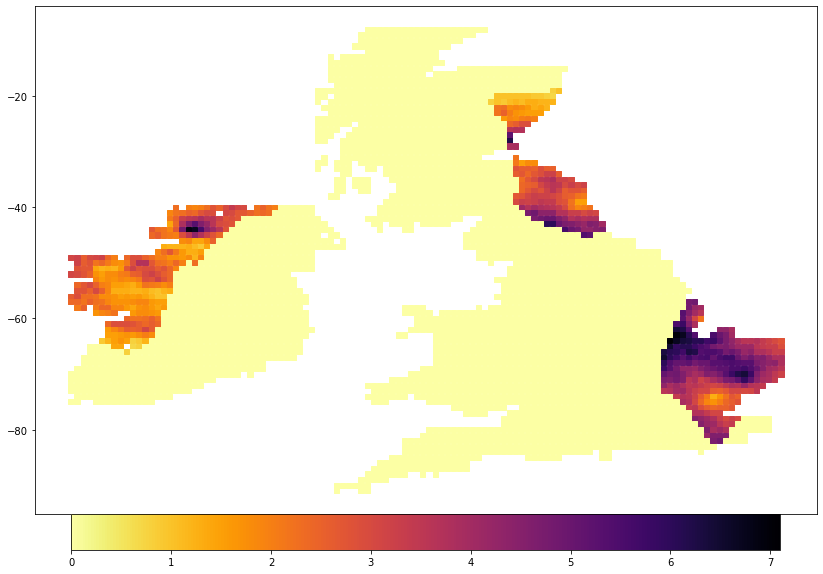

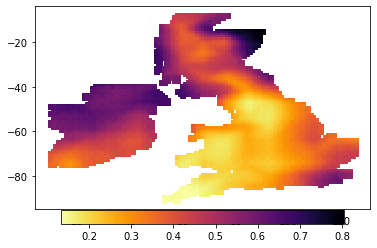

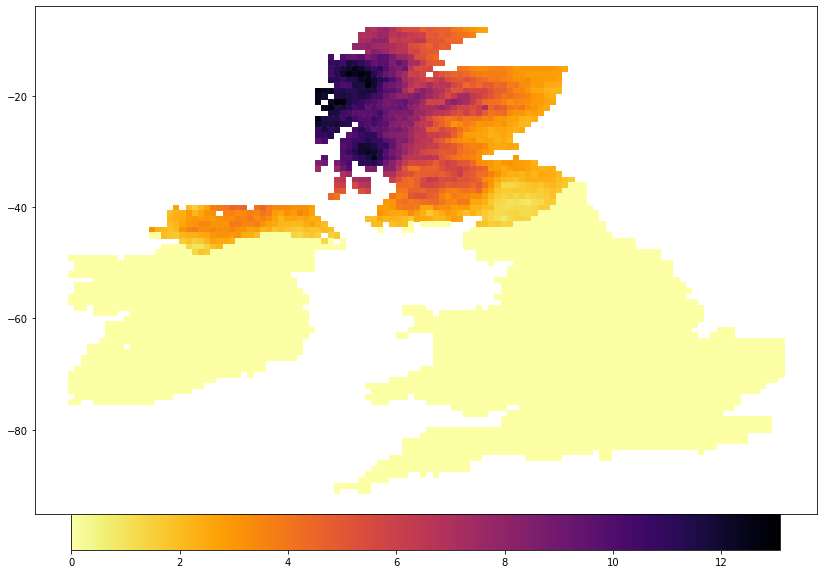

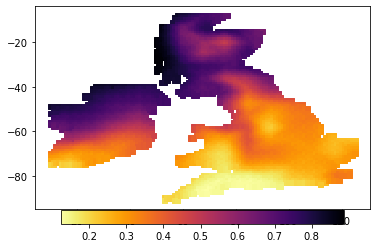

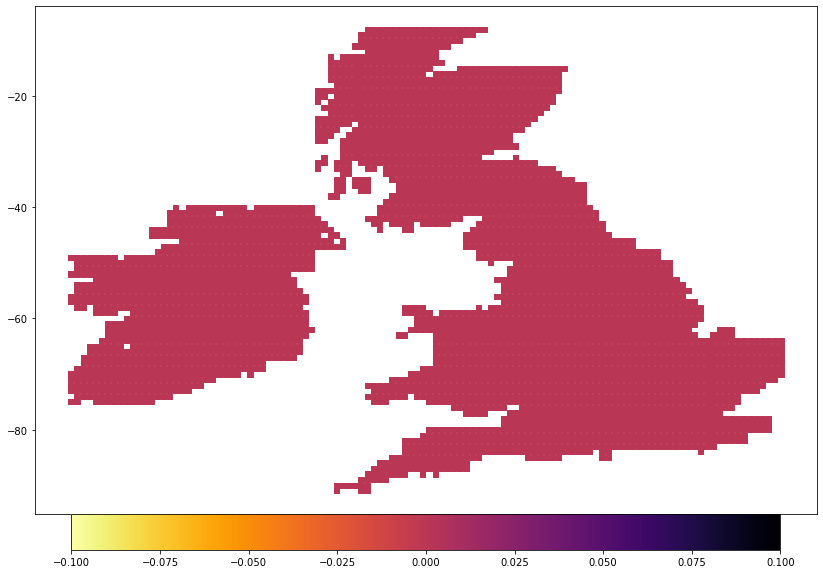

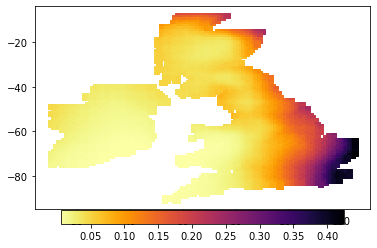

  0%|          | 0/7031 [18:03<?, ?it/s]


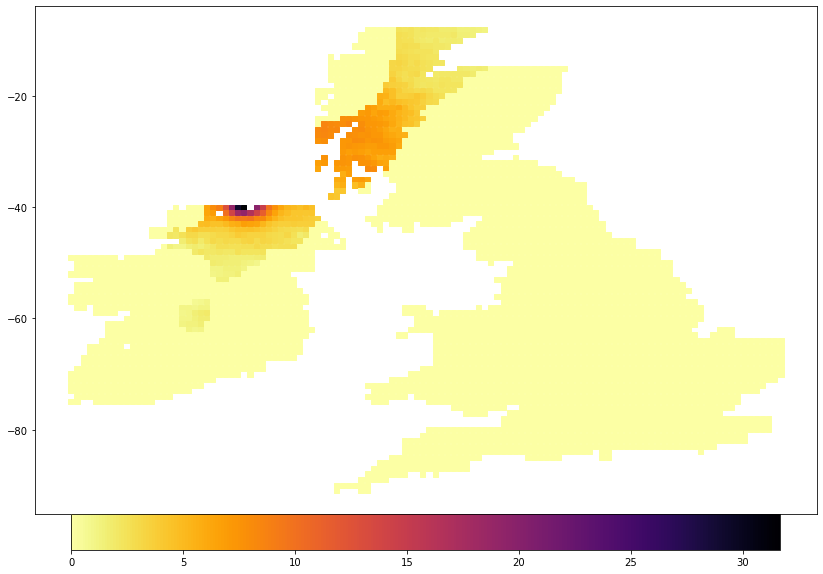

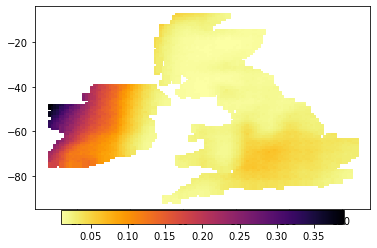

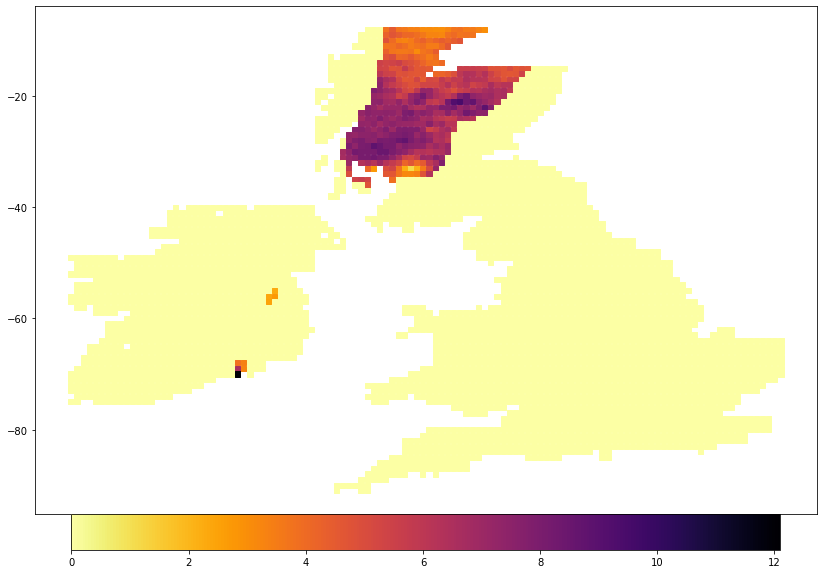

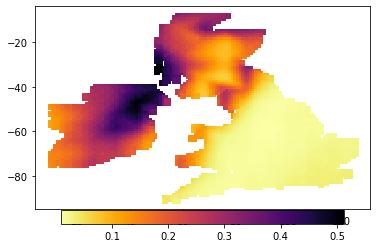

In [130]:
# Plotting order on map
for day in range(10):
    fig = plt.gcf()
    fig.set_size_inches(14,10)
    color = plt.cm.rainbow(np.linspace(0, 1, len(GNM_landonly)))
    plt.scatter([GNM_landonly[loc][5][1] for loc in range(len(GNM_landonly))],[-GNM_landonly[loc][5][0] for loc in range(len(GNM_landonly))],c=[GNM_landonly[loc][3][day] for loc in range(len(GNM_landonly))],cmap='inferno_r',s=27,marker='s')
    plt.colorbar(location='bottom',fraction=0.0652,pad=0.001)

    plt.show()

    plt.scatter([GNM_landonly[loc][5][1] for loc in range(len(GNM_landonly))],[-GNM_landonly[loc][5][0] for loc in range(len(GNM_landonly))],c=[GNM_landonly[loc][4][day] for loc in range(len(GNM_landonly))],cmap='inferno_r',s=27,marker='s')
    plt.colorbar(location='bottom',fraction=0.0652,pad=0.001)

    plt.show()

In [198]:
# Run this block to simulate. Change values at the top for day, samples, etc... Takes ~1:30m for all locations.

sim_day = 0
sim_locations = range(2000)
kernel_type = 'Matern'
theta_values = [800,10] # MLE gave [4.01,3.08]
nb_samples = 10

#################################################################### Do not touch the rest ####################################################################

# Utility function
def g_Finv(day_id,loc_id,u): # take u to a value of rain according to the gamma density for that day and location
    if 1-GNM_landonly[loc_id][4][day_id]>=u: #if 1-p>u, invcdf is 0 rain
        return 0
    else: # invcdf( (u-1+p) /p)
        return scs.gamma(scale=GNM_landonly[loc_id][1][day_id]*GNM_landonly[loc_id][0][day_id],a=1/GNM_landonly[loc_id][1][day_id]).ppf((u-1+GNM_landonly[loc_id][4][day_id])/GNM_landonly[loc_id][4][day_id])

# Define censor levels pi on normal scale := di. This is done for the whole dataset, no need to touch.

#censored_di = [[GNM_landonly[loc][4][day] for loc in range(4087)] for day in tqdm(range(7031))] # di[day][loc]
#censored_di = scs.norm.ppf(np.array(censored_di))

# Simulating Draws. Dependent on given day and locations.
simulated_us = truncgauss(dist_mat[:max(sim_locations),:max(sim_locations)]).sim(theta=theta_values,inv_us=censored_di,draws=nb_samples,day_idx=sim_day,kernel=kernel_type)
simulated_rain = [[g_Finv(sim_day,loc,simulated_us[draw][loc]) for loc in range(len(simulated_us[0]))] for draw in range(len(simulated_us))]

print('Simulations done!')

Simulations done!


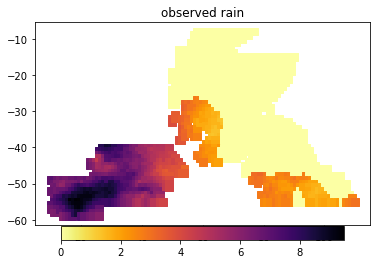

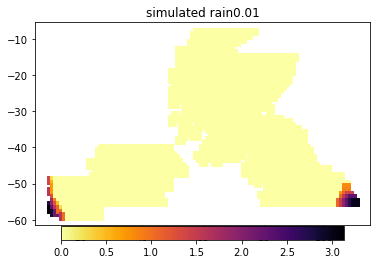

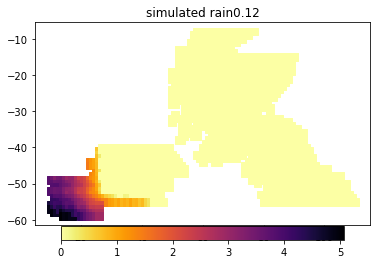

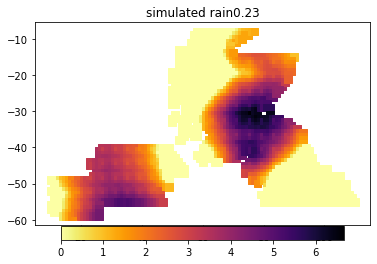

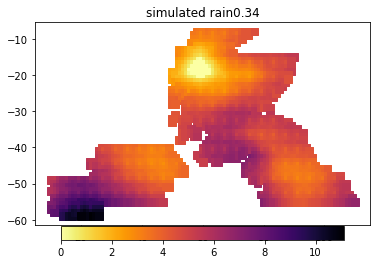

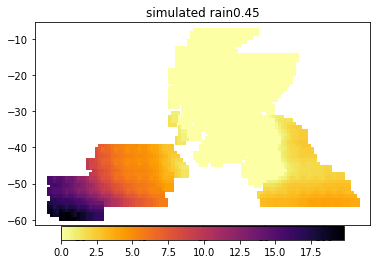

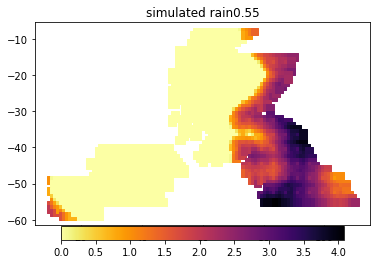

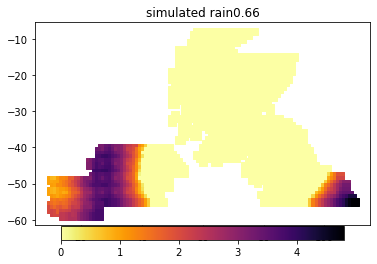

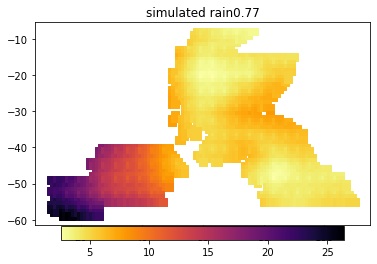

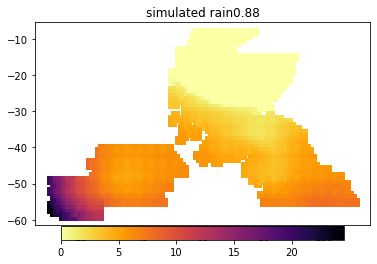

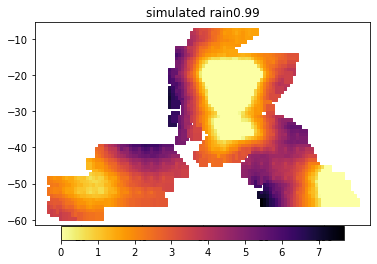

In [199]:
# Plotting simulated vs observed rain
for day in [sim_day]:
    fig = plt.gcf()
    color = plt.cm.rainbow(np.linspace(0, 1, len(GNM_landonly)))
    plt.scatter([GNM_landonly[loc][5][1] for loc in sim_locations[:-1]],[-GNM_landonly[loc][5][0] for loc in sim_locations[:-1]],c=[GNM_landonly[loc][3][day] for loc in sim_locations[:-1]],cmap='inferno_r',s=60,marker='s')
    plt.colorbar(location='bottom',fraction=0.0652,pad=0.001)
    plt.title('observed rain')
    plt.show()
    for draw in range(nb_samples):
        plt.scatter([GNM_landonly[loc][5][1] for loc in sim_locations[:-1]],[-GNM_landonly[loc][5][0] for loc in sim_locations[:-1]],c=simulated_rain[draw],cmap='inferno_r',s=60,marker='s')
        plt.colorbar(location='bottom',fraction=0.0652,pad=0.001)
        plt.title('simulated rain'+str(round(np.linspace(0.01,0.99,nb_samples)[draw],2)))
        plt.show()